STEP 1 : IMPORT ALL THE ESSENTIAL LIBRARIES REQUIRED TO EXECUTE IN-DEPTH ANALYSIS

In [ ]:
import pandas as pd
## We are using a tool called IsolationForest, which helps us find unusual things or 'outliers' in our data.
from sklearn.ensemble import IsolationForest 
## LabelEncoder helps us transform words into numbers so that the computer can understand and work with them more easily.
from sklearn.preprocessing import LabelEncoder 
##train_test_split lets us divide our data into two separate parts: one for teaching the computer, and one for testing how well it learned.
from sklearn.model_selection import train_test_split 
# RandomForestRegressor is a very smart computer helper that can make predictions about numbers by looking at lots of patterns in the data.
from sklearn.ensemble import RandomForestRegressor
# matplotlib.pyplot helps us make charts and graphs so we can see our results visually, much like making a bar chart in Excel.
import matplotlib.pyplot as plt
# sqlite3 helps us talk to a simple database where we can store and retrieve information.(More like what we do in MySQL)
import sqlite3

STEP 2: LOAD THE CLEANED CSV DATA FROM THE SYSTEM 

In [ ]:
#this command reads the cleaned data from a CSV file located on your computer and loads it into a table-like structure called a DataFrame, which is great for data analysis.
df=pd.read_csv('C:/Users/CONFUSED CRUSADER/newfolder/ev_clean_data.csv')
#prints the first five datasets in the DataFrame to give you a quick look at what the data looks like.
print(df.head())

   Year Month_Name      Date           State         Vehicle_Class  \
0  2014        Jan  1/1/2014  Andhra Pradesh       Adapted Vehicle   
1  2014        Jan  1/1/2014  Andhra Pradesh  Agricultural Tractor   
2  2014        Jan  1/1/2014  Andhra Pradesh             Ambulance   
3  2014        Jan  1/1/2014  Andhra Pradesh   Articulated Vehicle   
4  2014        Jan  1/1/2014  Andhra Pradesh                   Bus   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       Others                0.0  
4              Bus          Bus                0.0  


STEP 3: CREATE DATABASE FOR EXECUTION OF SQL TASKS 

In [ ]:
# This line opens or creates a file called 'ev_sales.db', which acts like a digital filing cabinet to store information we want to keep.
conn = sqlite3.connect('ev_sales.db')

"""This line takes all our data (found in something called 'df'), and puts it into our digital cabinet under a specific section named 'ev_table'.
 If that section already exists, it will be completely replaced with the new data so it's always up-to-date."""
df.to_sql('ev_table', conn, if_exists='replace', index=False)


94953

STEP 4: PERFORM SQL TASKS FOR FILTERATION OF ESSENTIAL DATASETS WHICH WILL BE USEFUL FOR OUR PREDICTIVE ANALYSIS 

In [ ]:
# This line starts a process to create a new, cleaner table named 'ev_table_dedup'.
# The new table keeps only unique (non-duplicate) records based on columns like Year, Month, Date, State, and various vehicle details.
conn.execute('''
CREATE TABLE ev_table_dedup AS
SELECT DISTINCT Year, Month_Name, Date, State, Vehicle_Class, Vehicle_Category, Vehicle_Type, EV_Sales_Quantity
FROM ev_table;
''')
# This line saves the changes made so far and makes sure the new table is actually stored in our storage box (the database).
conn.commit()

# This line removes (deletes) the old table named 'ev_table' from our storage box,
# since we want to keep only the new, cleaned table and not the previous version.
conn.execute('DROP TABLE ev_table;')

# This line renames the new, cleaned table ('ev_table_dedup') to use the old table's name ('ev_table').
# This is done so everything continues to work as before, but now using the improved data.
conn.execute('ALTER TABLE ev_table_dedup RENAME TO ev_table;')

# This line saves all the above changes for good, so our storage box is now fully updated.
conn.commit()


In [ ]:
# This line updates our table called 'ev_table', focusing on the EV_Sales_Quantity column (which holds the number of electric vehicle sales).
# If the sales quantity for any record is missing (blank or unknown), this line changes that value to 0 instead of leaving it empty.
conn.execute('''
UPDATE ev_table
SET EV_Sales_Quantity = 0
WHERE EV_Sales_Quantity IS NULL;
''')

# This line saves all the changes made, making sure our data storage is now fully updated and correct.
conn.commit()

In [ ]:
# This part creates a question (called a query) for our database, asking it to add up (sum) the sales of electric vehicles.
# The question groups the results by year, month, state, and vehicle type so we can see totals for each category.
query = '''
SELECT Year, Month_Name, State, Vehicle_Type, SUM(EV_Sales_Quantity) AS Total_Monthly_Sales
FROM ev_table
GROUP BY Year, Month_Name, State, Vehicle_Type;
'''
# This line sends our question to the database and collects the answer as a table that we can work with in Python (using pandas)
df_agg = pd.read_sql(query, conn)
# prints the first few rows of the answer table, helping us quickly check what the data looks like.
print(df_agg.head())


   Year Month_Name                     State Vehicle_Type  Total_Monthly_Sales
0  2014        Apr  Andaman & Nicobar Island  2W_Personal                  0.0
1  2014        Apr  Andaman & Nicobar Island    3W_Shared                  0.0
2  2014        Apr  Andaman & Nicobar Island  4W_Personal                  0.0
3  2014        Apr  Andaman & Nicobar Island    4W_Shared                  0.0
4  2014        Apr  Andaman & Nicobar Island          Bus                  0.0


In [ ]:
# This section writes a question to the database (called a query).
# It asks for everything (*) from our data and also creates two new columns:
# - One column ('Month_Num') picks out the month part from the Date for each record.
# - Another column ('Year_Num') picks out the year part from the Date for each record.
query = '''
SELECT *,
    CAST(SUBSTR(Date, 1, INSTR(Date, '/')-1) AS INTEGER) AS Month_Num,
    CAST(SUBSTR(Date, LENGTH(Date) - 3, 4) AS INTEGER) AS Year_Num
FROM ev_table;
'''

df_time = pd.read_sql(query, conn)
print(df_time[['Date', 'Month_Num', 'Year_Num']].head())


       Date  Month_Num  Year_Num
0  1/1/2014          1      2014
1  1/1/2014          1      2014
2  1/1/2014          1      2014
3  1/1/2014          1      2014
4  1/1/2014          1      2014


In [ ]:
# This line asks the database for a list of all unique states where sales data exists.
# It collects the results into a table called 'states' so we can easily use it later.
states = pd.read_sql('SELECT DISTINCT State FROM ev_table;', conn)

# This line asks the database for a list of all unique vehicle types found in the sales data.
# It collects the results into a table called 'vehicle_types'.
vehicle_types = pd.read_sql('SELECT DISTINCT Vehicle_Type FROM ev_table;', conn)
#prints the first few states and vehicle  for checking purposes
print(states.head())
print(vehicle_types.head())


                      State
0            Andhra Pradesh
1         Arunachal Pradesh
2                     Assam
3  Andaman & Nicobar Island
4                     Bihar
      Vehicle_Type
0           Others
1              Bus
2  Institution Bus
3      2W_Personal
4        4W_Shared


In [ ]:
# This part creates a special question (query) for our data:
# We are asking the database to give us all the records (rows) from our table where EV sales look unusually high.
# It checks for records where 'EV_Sales_Quantity' is much bigger than normal by using a mathematical formula:

#  The formula says: find records where sales are greater than the average sales plus three times the difference between the biggest and smallest sales numbers in the table.
# The purpose of using the formula  to identify extreme values in the sales data
# This formula helps find sales numbers that are unusually high compared to the typical range of sales.
query = '''
SELECT *
FROM ev_table
WHERE EV_Sales_Quantity > (
  SELECT AVG(EV_Sales_Quantity) + 3 * ( ( (SELECT MAX(EV_Sales_Quantity) FROM ev_table) - (SELECT MIN(EV_Sales_Quantity) FROM ev_table) ) / 6 )  -- Approximate stddev
  FROM ev_table
);
'''
# This line gets the answer to our question from the database—the records with unusually high electric vehicle sales—
# and puts them into a table called 'outliers' that we can use in Python.
outliers = pd.read_sql(query, conn)
# This line shows us the first few of these unusual records so we can quickly see them on our screen.
print(outliers.head())


   Year Month_Name      Date          State    Vehicle_Class Vehicle_Category  \
0  2023        Jan  1/1/2023    Maharashtra  M-Cycle/Scooter       2-Wheelers   
1  2023        Jan  1/1/2023  Uttar Pradesh    E-Rickshaw(P)       3-Wheelers   
2  2024        Jan  1/1/2024  Uttar Pradesh    E-Rickshaw(P)       3-Wheelers   
3  2024        Jan  1/1/2024    Maharashtra  M-Cycle/Scooter       2-Wheelers   
4  2023        Feb  2/1/2023    Maharashtra  M-Cycle/Scooter       2-Wheelers   

         Vehicle_Type  EV_Sales_Quantity  
0         2W_Personal            13289.0  
1  3W_Shared_Lowspeed            13882.0  
2  3W_Shared_Lowspeed            17780.0  
3         2W_Personal            15874.0  
4         2W_Personal            11761.0  


In [ ]:
# this line asks the database for everything (*) from our table called 'ev_table'.
# previously, while data cleaning process , i was unware of the fact that yyyy/mm/dd format can cause ambiguity(confusions) in some SQL engines, which later i realized while coding

query = 'SELECT * FROM ev_table;'
df = pd.read_sql(query, conn)
print(df.head())

   Year Month_Name      Date           State         Vehicle_Class  \
0  2014        Jan  1/1/2014  Andhra Pradesh       Adapted Vehicle   
1  2014        Jan  1/1/2014  Andhra Pradesh  Agricultural Tractor   
2  2014        Jan  1/1/2014  Andhra Pradesh             Ambulance   
3  2014        Jan  1/1/2014  Andhra Pradesh   Articulated Vehicle   
4  2014        Jan  1/1/2014  Andhra Pradesh                   Bus   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       Others                0.0  
4              Bus          Bus                0.0  


In [ ]:

# Convert 'Date' column to datetime format with the correct format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Extract numeric month and year into new columns
df['Month_Num'] = df['Date'].dt.month
df['Year_Num'] = df['Date'].dt.year

# Check the first few rows to verify new columns
print(df[['Date', 'Month_Num', 'Year_Num']].head())


        Date  Month_Num  Year_Num
0 2014-01-01          1      2014
1 2014-01-01          1      2014
2 2014-01-01          1      2014
3 2014-01-01          1      2014
4 2014-01-01          1      2014


STEP 5: PREPARING DATASETS FOR  IN DEPTH PREDICTION OF EV SALES (USE OF LABELS , TRAINING DATASETS FOR ML MODELS WHICH IS CRUCIAL FOR PREDICTION)

In [ ]:
import pandas as pd
# This line brings in IsolationForest, a tool that helps us find values that look unusual or don't fit with the rest of the data.
from sklearn.ensemble import IsolationForest
# This line brings in LabelEncoder, which is used to turn words or categories into numbers so the computer can easily understand and use them.
from sklearn.preprocessing import LabelEncoder
# This line brings in train_test_split, which allows us to divide our data into two groups: one to teach the computer (training) and another to check how well it learned (testing).
from sklearn.model_selection import train_test_split
# This line brings in RandomForestRegressor, which is a smart model that can predict numbers (like prices or quantities) by learning from past data patterns.
from sklearn.ensemble import RandomForestRegressor
# This line brings in matplotlib's pyplot, a toolkit for drawing graphs and charts to help us see and understand patterns and trends in the data.
import matplotlib.pyplot as plt
# This line brings in seaborn, another tool for creating beautiful graphs and charts that make our data easier to understand.
import seaborn as sns

In [ ]:
# This line creates a blank dictionary called 'label_encoders' to store our tools for turning words into numbers later on.
label_encoders = {}

# Here, we make a list called 'categorical_cols' with the names of all the columns that contain words instead of numbers.
# These might describe things like the state, vehicle class, vehicle category, and type of vehicle.
categorical_cols = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type']

# This loop goes through each column name in our list, one at a time.
for col in categorical_cols:
    # For each column, we create a LabelEncoder tool, which will help us turn words into numbers.
    le =LabelEncoder()
    # This line changes the actual data in that column by replacing each word with a unique number, so the computer can use it for analysis.
    df[col] = le.fit_transform(df[col])
    # This line stores the LabelEncoder tool we used for this column so that we can use it again later if needed (for example, to convert numbers back to words).
    label_encoders[col] = le

In [ ]:
# Here, we define which columns we want to use as features (inputs) for our prediction model and which column we want to predict (output).
# 'feature_cols' contains the names of the columns that will help us make predictions, 
feature_cols = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'Month_Num', 'Year_Num']
X = df[feature_cols]
# while 'y' is the column we want to predict, which in this case is the quantity of electric vehicle sales.
y = df['EV_Sales_Quantity']


In [ ]:

# This line splits our data into two parts: one part (80%) to teach the computer (training set) and another part (20%) to test how well it learned (testing set).
feature_cols = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'Month_Num', 'Year_Num']
X = df[feature_cols]
y = df['EV_Sales_Quantity']

# We use a random method to decide which records go into each part, and we set a specific starting point (random_state=42) to make sure we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


STEP 6:USING MACHINE LEARNING MODELS TO PREDICT THE EV SALES DURING 2014 TO 2024 (THIS DATA WILL PLAY AS A REFRENCE MODEL FOR FUTURE FORCASTING(2025-2035))


In [ ]:
# This line brings in GridSearchCV, a tool that helps us automatically find the best settings for our prediction model.
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
# This line brings in two helpers, mean_squared_error and r2_score, to check how well our predictions match the real results.
from sklearn.metrics import mean_squared_error, r2_score

# Here we make a list called param_grid, which has different sets of settings that our prediction model can try out.
# For example, we test how many trees to use, how deep each tree can go, and how many data points are needed.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# This line makes a RandomForestRegressor, which is our main prediction tool for this task.
rf = RandomForestRegressor(random_state=42)

# This line prepares GridSearchCV to test all the different settings in param_grid using our prediction tool.
# It will check which settings give us the best results by dividing the data and scoring the results.
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# This line starts the process of testing all the settings using the training data to see which combination works best.
grid_search.fit(X_train, y_train)
# This line prints out the set of settings (parameters) that gave the best prediction results.
print("Best parameters:", grid_search.best_params_)

# This line pulls out the model with the best settings, so we can use it for making predictions on new data.
best_rf = grid_search.best_estimator_
# This line uses the best model to predict electric vehicle sales for each entry in our data, adding the results to our spreadsheet under 'Predicted_EV_Sales'.
df['Predicted_EV_Sales'] = best_rf.predict(X)



Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


FINE TUNING THE PREDICTED EV SALES USING GRIDSEARCH

In [47]:
best_model = grid_search.best_estimator_
df['Predicted_EV_Sales'] = best_model.predict(X)

PLOTTING  SOME GRAPHS IN ORDER TO CHECK IF PREDICTED EV SALES ARE WORKING OR NOT 


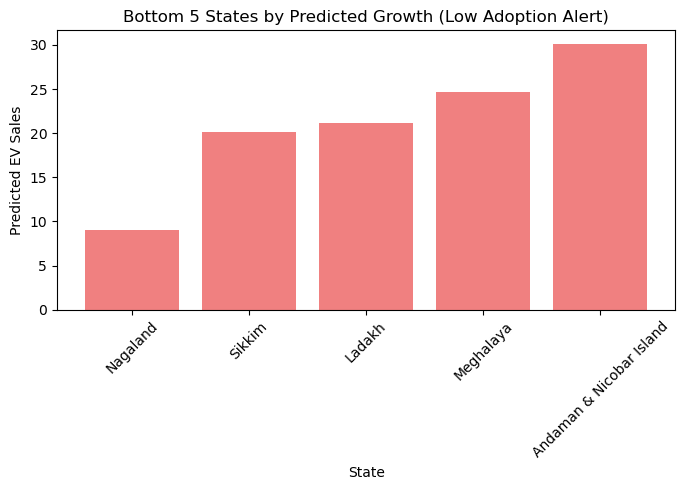

In [ ]:
# This line finds the most recent year in your data, so the analysis is focused on the latest information.
latest_year = df['Year_Num'].max()
# This line finds the top 5 states (regions) with the highest predicted electric vehicle sales for that latest year.
top_states = df[df['Year_Num'] == latest_year].groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=False).head(5)
# This line converts the state codes (numbers) in top_states back into readable labels (state names), using the previous encoders.
top_state_labels = [label_encoders['State'].inverse_transform([state])[0] for state in top_states.index]
# This line finds the bottom 5 states with the lowest predicted EV sales for the latest year (those with least adoption).
bottom_states = df[df['Year_Num'] == latest_year].groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=True).head(5)
# This line converts the state codes in bottom_states back to labels (real state names) for easy reading on a chart.
bottom_state_labels = [label_encoders['State'].inverse_transform([state])[0] for state in bottom_states.index]
# This sets up the size (width and height) of your chart for better visibility.
plt.figure(figsize=(7,5))
# This draws a bar chart showing the bottom 5 states and their predicted EV sales, using a soft red color for the bars.
plt.bar(bottom_state_labels, bottom_states.values, color='lightcoral')

# This adds a title at the top of the chart to explain what it's showing.
plt.title('Bottom 5 States by Predicted Growth (Low Adoption Alert)')
# This labels the horizontal axis to make clear that each bar stands for a different state.
plt.xlabel('State')
# This labels the vertical axis, showing that the height of each bar means predicted EV sales.
plt.ylabel('Predicted EV Sales')
# This turns the names on the horizontal axis to an angle, so they're easier to read and don't overlap.
plt.xticks(rotation=45)
# This makes sure the chart components fit nicely and don't get cut off or squished.
plt.tight_layout()
# This shows the final finished chart on your screen.
plt.show()





THIS GRAPH CONFIRMS THE WORKING  OF OUR PREDICTED EV SALES THAT WE FOUND OUT USING RandomForestRegressor AND FINE TUNING USING GridSearchCV

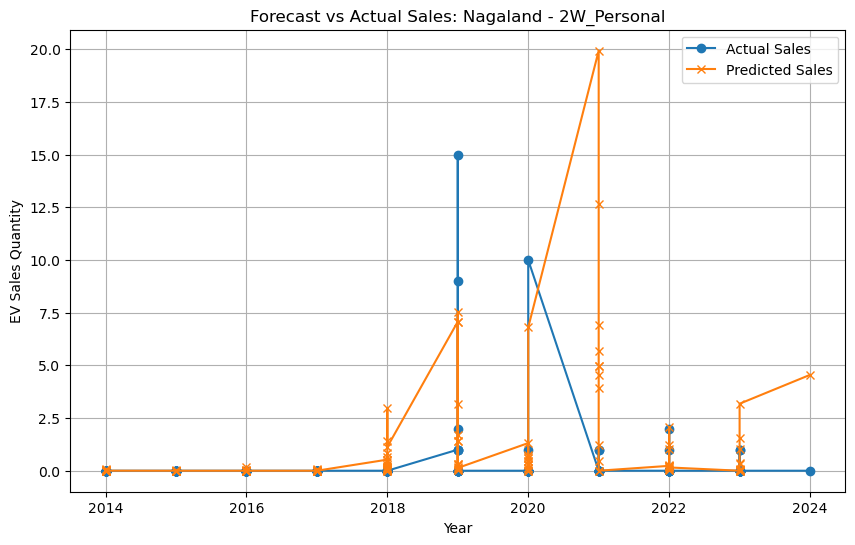

In [ ]:
# This sets the name of the state we want to analyze, for example 'Nagaland'.
selected_state_name = 'Nagaland' 
# This sets the type of vehicle we want to look at, for example '2W_Personal' (two-wheeler, personal use). 
selected_vehicle_type_name = '2W_Personal'  
# This converts the state name into a numerical code, so the computer can use it to filter data.
state_code = label_encoders['State'].transform([selected_state_name])[0]
# This converts the vehicle type name into a numerical code for filtering the data.
vehicle_type_code = label_encoders['Vehicle_Type'].transform([selected_vehicle_type_name])[0]

# This creates a filtered table containing only the records for the selected state and selected vehicle type.
# The records are also sorted by year, so we see the trend over time.
df_filtered = df[(df['State'] == state_code) & (df['Vehicle_Type'] == vehicle_type_code)].sort_values('Year_Num')
# This sets the size of the chart to make it large and easy to read.
plt.figure(figsize=(10,6))
# This draws a line on the chart showing the actual number of electric vehicles sold each year.
plt.plot(df_filtered['Year_Num'], df_filtered['EV_Sales_Quantity'], label='Actual Sales', marker='o')
# This draws another line on the same chart, but this time for the predicted or forecasted sales for each year.
plt.plot(df_filtered['Year_Num'], df_filtered['Predicted_EV_Sales'], label='Predicted Sales', marker='x')
# This adds a title to the chart, mentioning the chosen state and vehicle type so viewers know what they are looking at.
plt.title(f'Forecast vs Actual Sales: {selected_state_name} - {selected_vehicle_type_name}')

# This adds a label at the bottom of the chart, showing that the horizontal axis represents years.
plt.xlabel('Year')
# This labels the side of the chart, making clear that the vertical axis is for the number of electric vehicles sold.
plt.ylabel('EV Sales Quantity')
# This adds a legend so viewers can tell which line shows actual sales and which shows predicted sales.
plt.legend()
# This adds a grid to the chart, making it easier to follow values across the chart.
plt.grid(True)
plt.show()





MONTHLY SALES TRENDS IN GOA (THIS GRAPH WILL PLAY A CRUCIAL ROLE FOR MY PRESENTATION FILE  )

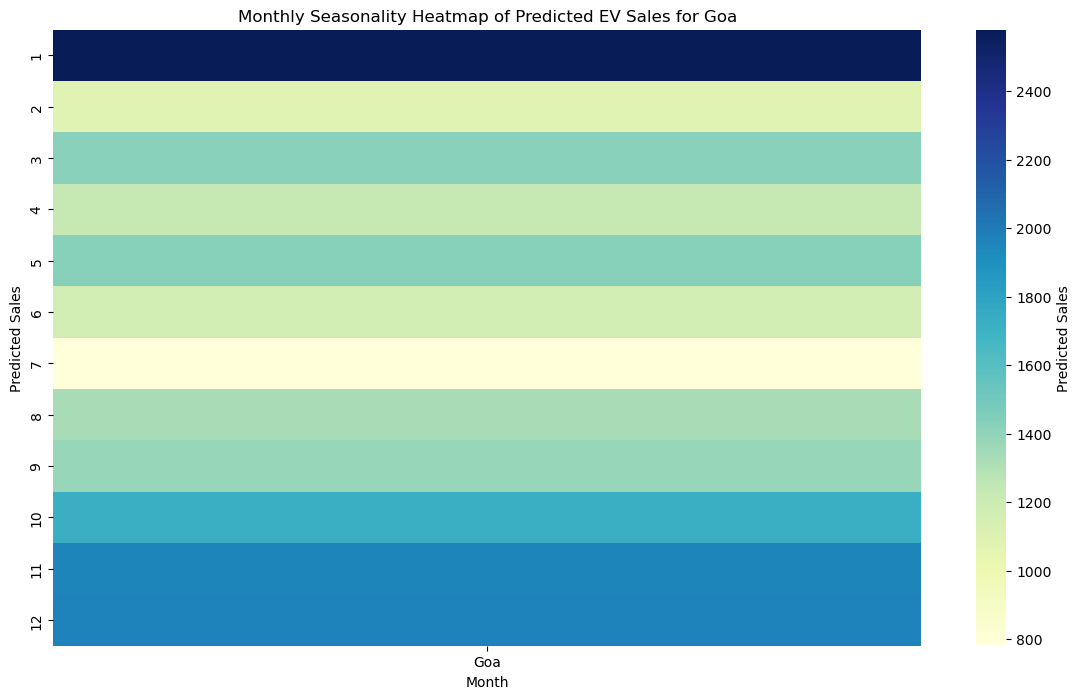

In [ ]:
# This groups the data by both 'State' and 'Month_Num', then adds up all the predicted sales for each group.
# The result is a table of predicted electric vehicle sales for each state and each month.
seasonality = df.groupby(['State', 'Month_Num'])['Predicted_EV_Sales'].sum().unstack()
# This converts the state codes in the table back into their actual state names so people can understand the results.
state_labels = label_encoders['State'].inverse_transform(seasonality.index)
# This sets the labels (now real state names) as the index (row names) of the table, making the table easy to read.
seasonality.index = state_labels
# This sets the size of the visualization, making it large and clear.
plt.figure(figsize=(14,8))
# This creates a colorful heatmap for Goa, showing predicted sales for each month.
# The brighter or darker the color, the higher or lower the predicted sales.
sns.heatmap(seasonality.loc[['Goa']].T, cmap='YlGnBu', cbar_kws={'label': 'Predicted Sales'})
# This gives the chart a title, explaining that it's about monthly sales predictions for Goa.
plt.title('Monthly Seasonality Heatmap of Predicted EV Sales for Goa')
# This labels the horizontal axis with 'Month', since we are showing monthly changes.
plt.xlabel('Month')
# This labels the vertical axis, making clear the colors show the number of predicted vehicle sales.
plt.ylabel('Predicted Sales')
plt.show()




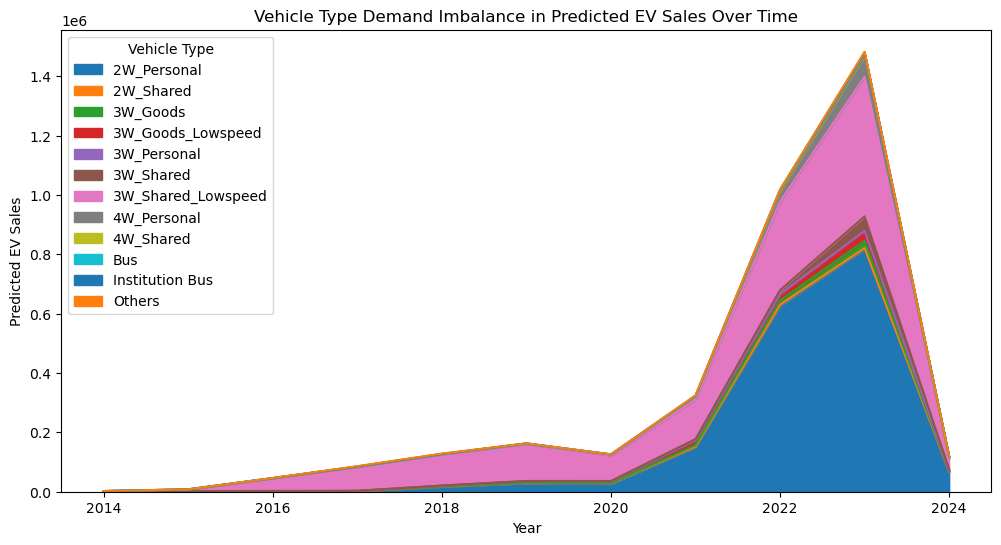

In [ ]:
# This line groups the data first by year and by vehicle type, then adds up all the predicted sales for each kind of vehicle in each year.
# If any data is missing, it fills it in with 0, so our table stays complete.
agg_vehicle = df.groupby(['Year_Num', 'Vehicle_Type'])['Predicted_EV_Sales'].sum().unstack().fillna(0)
# This line converts vehicle type codes (like numbers) back to their original, understandable names so the chart is easier to read.
vehicle_names = label_encoders['Vehicle_Type'].inverse_transform(agg_vehicle.columns)
# This sets the columns of the table to use the readable vehicle type names, making the results clear for viewers.
agg_vehicle.columns = vehicle_names

# This draws a stacked area chart (like layers of colored hills), showing how demand for each vehicle type changes each year over time.
# Each color represents a different vehicle type and the chart is wide for better viewing.
agg_vehicle.plot(kind='area', stacked=True, figsize=(12,6))
# This adds a title to the chart, clearly explaining that it’s about demand for each type of electric vehicle over time.
plt.title('Vehicle Type Demand Imbalance in Predicted EV Sales Over Time')
# This labels the horizontal axis to show that it represents years.
plt.xlabel('Year')
# This labels the side axis so viewers know it’s displaying the number of predicted electric vehicle sales.
plt.ylabel('Predicted EV Sales')
# This adds a legend box so that it’s easy to see which color stands for which vehicle type.
plt.legend(title='Vehicle Type')
plt.show()




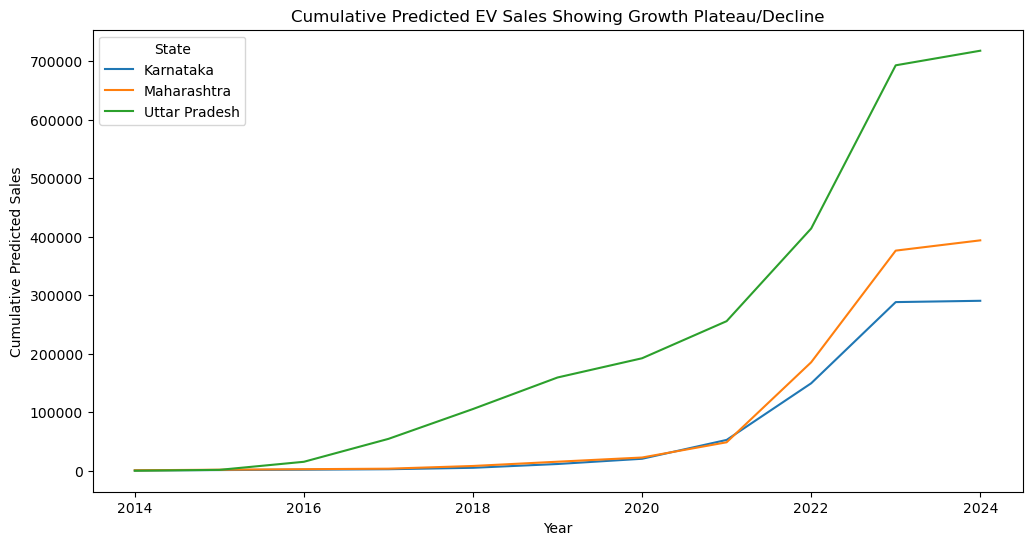

In [ ]:
# This groups the data by state and year, then adds up all predicted EV sales over the years for each state.
# It also calculates a running total, so we can see how predictions build up year-by-year in each state.
cumulative = df.groupby(['State', 'Year_Num'])['Predicted_EV_Sales'].sum().groupby(level=0).cumsum().reset_index()
# This finds the top 3 states with the highest predicted cumulative sales by looking for the largest sum in each state.
top_states = cumulative.groupby('State')['Predicted_EV_Sales'].max().nlargest(3).index
# This converts the state codes (numbers) back to their actual names so we can show nice labels in the chart.
state_labels = label_encoders['State'].inverse_transform(top_states)
# This keeps only the results for the top 3 states, so our chart shows their growth patterns clearly.
cumulative_top = cumulative[cumulative['State'].isin(top_states)]

# Sets the size of the chart so it’s large and clear to view.
plt.figure(figsize=(12,6))
# This draws a line chart for each of the top states, showing how their predicted sales build up each year.
# Each line is given a color and label so viewers can easily compare state growth trends.
sns.lineplot(data=cumulative_top, x='Year_Num', y='Predicted_EV_Sales', hue=cumulative_top['State'].map(dict(zip(top_states, state_labels))))
# Adds a chart title, explaining that it shows cumulative predictions and whether growth is leveling off or decreasing.
plt.title('Cumulative Predicted EV Sales Showing Growth Plateau/Decline')
# Labels the horizontal axis so viewers know it’s the year.
plt.xlabel('Year')
# Labels the vertical axis so viewers know it shows total predicted electric vehicle sales so far.
plt.ylabel('Cumulative Predicted Sales')
# Adds a legend box so viewers can tell which color stands for which state.
plt.legend(title='State')
plt.show()


STEP 7: WE WILL USE RandomForestRegressor AND GridSearchCV AGAIN , BUT THIS TIME TO PREDICT THE FUTURE EV SALES(2025-2035) (USING THE PREDICTED EV SALES WE FOUND OUT AS OUR REFERENCE MODEL)

In [ ]:
# This brings in RandomForestRegressor—a smart prediction tool—and GridSearchCV—a helper that automatically finds the best settings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# -------- Prepare Data for Training --------
# This part selects data from 2024 and before, to teach the computer how things worked in the past.
train_df = df[df['Year_Num'] <= 2024]
# This lists the columns we will use as input features to help the computer learn.
features = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'Month_Num', 'Year_Num']
# This grabs only the input features (columns) from our training data.
X_train = train_df[features]
# This grabs the results—the numbers we want to predict (EV sales)—from our training data.
y_train = train_df['EV_Sales_Quantity']

# -------- Choose Model and Settings to Test --------
# Create the main prediction tool, setting up randomness so results are repeatable.
rf = RandomForestRegressor(random_state=42)
# This creates a list of model settings for GridSearchCV to test (like choosing how many trees to use, tree depth, etc.).
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# -------- Automatic Testing with GridSearchCV --------
# This sets up the helper to test all model settings using the training data, checking which settings predict sales most accurately.
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
# This prints out the settings that worked best for making predictions, so we know what our model should use.
print("Best parameters found:", grid_search.best_params_)

# -------- Get Best Model --------
# This saves the best version of our prediction tool found through GridSearchCV.
best_model = grid_search.best_estimator_


# -------- Prepare Future Scenarios --------
# This imports a helper to create every possible combination for future predictions.
import itertools
future_years = [2025, 2026, 2027,2028,2029,2030,2031,2032,2033,2034,2035]
# These lines find all possible categories in our data for states, vehicle classes, categories, types, and months.
states = df['State'].unique()
vehicle_classes = df['Vehicle_Class'].unique()
vehicle_categories = df['Vehicle_Category'].unique()
vehicle_types = df['Vehicle_Type'].unique()
months = range(1, 13)
# This creates every possible combination of future data (state, class, type, etc.) for all the years and months.
future_rows = list(itertools.product(states, vehicle_classes, vehicle_categories, vehicle_types, months, future_years))
# This puts all the combinations into a neat table with the right labels.
future_df = pd.DataFrame(future_rows, columns=['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'Month_Num', 'Year_Num'])

# -------- Predict Future Sales --------
# This line uses our best prediction tool to estimate how many electric vehicles could be sold in each possible future scenario.
future_df['Predicted_EV_Sales'] = best_model.predict(future_df[features])

print(future_df.head())





Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
   State  Vehicle_Class  Vehicle_Category  Vehicle_Type  Month_Num  Year_Num  \
0      1              0                 4            11          1      2025   
1      1              0                 4            11          1      2026   
2      1              0                 4            11          1      2027   
3      1              0                 4            11          1      2028   
4      1              0                 4            11          1      2029   

   Predicted_EV_Sales  
0             0.00875  
1             0.00875  
2             0.00875  
3             0.00875  
4             0.00875  


AND  HERE WE GO , THE FUTURE PROJECTED SALES FOR OUR EV COMPANY IS READY 

STEP 8: PLOTTING CRUCIAL GRAPHS TO FIND OUT TOP PERFORMING STATES, BOTTOM PERFORMING STATES , TOP VEHICLE CATEGORY ETC FOR OUR ANALYSIS

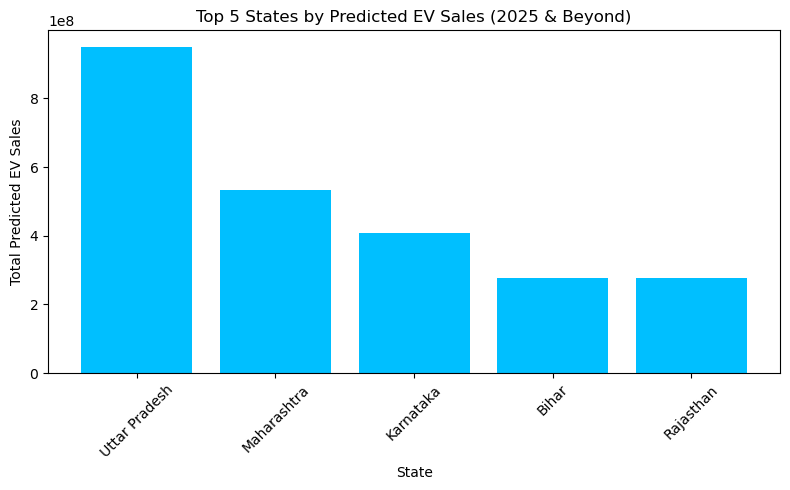

In [ ]:
import matplotlib.pyplot as plt

# This groups all the future predicted sales by state, adding them up for each state.
# It then sorts the states so the ones with the most predicted sales are at the top.
state_sales_future = future_df.groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=False)

# This selects just the top 5 states with the highest total predicted sales.
top5_state_sales = state_sales_future.head(5)
# This converts the state codes (which are numbers) back to real state names, making the chart easier to understand.
top5_state_labels = label_encoders['State'].inverse_transform(top5_state_sales.index)

# This sets the size of the chart so it looks big and clear.
plt.figure(figsize=(8,5))

# This draws a bar chart, with the state names on the bottom and their predicted sales shown as bars.
# The bars are colored 'deepskyblue' to stand out.
plt.bar(top5_state_labels, top5_state_sales.values, color='deepskyblue')
# This puts a title at the top of the chart to explain what is being shown.
plt.title('Top 5 States by Predicted EV Sales (2025 & Beyond)')
# This labels the horizontal axis so viewers know it shows different states.
plt.xlabel('State')
# This labels the vertical axis so it's clear we're looking at the total predicted number of EV sales.
plt.ylabel('Total Predicted EV Sales')
# This turns the state names on the axis a bit for better readability.
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TOP 5 STATES WITH VEHICLE TYPE BREAKDOWN

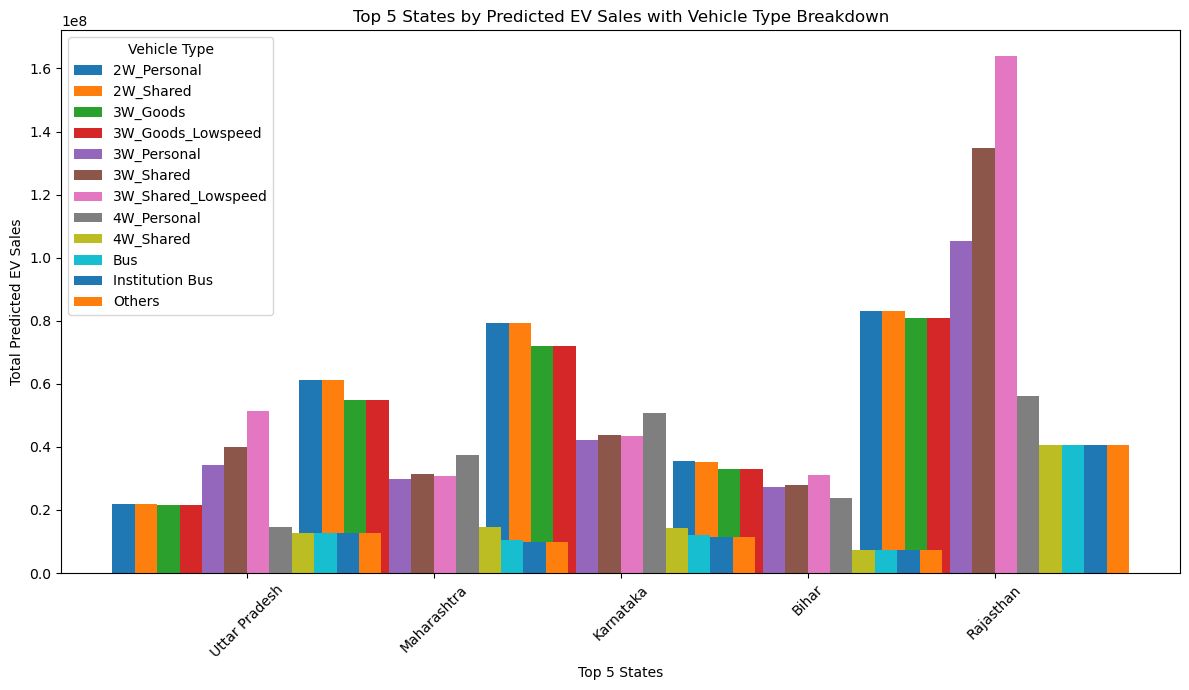

In [ ]:
import numpy as np
# This groups and adds up all predicted electric vehicle sales for each state from the future data, 
# then sorts the states so the highest total sales come first.
state_sales_future = future_df.groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=False)
# Picks just the top 5 states with greatest predicted sales.
top5_states = state_sales_future.head(5).index
# Converts these state codes (which are just numbers) back to real state names to display on charts.
top5_state_labels = label_encoders['State'].inverse_transform(top5_states)
# Narrows down the main data to only include entries from the selected top 5 states.
df_top5 = future_df[future_df['State'].isin(top5_states)]
# For those top 5 states, adds up all predicted EV sales, 
# grouped both by state and by type of vehicle, so we have totals for each type of vehicle in each state.
grouped = df_top5.groupby(['State', 'Vehicle_Type'])['Predicted_EV_Sales'].sum().unstack(fill_value=0)
# Converts the vehicle type codes (just numbers) back to readable vehicle type names for chart display.
vehicle_type_labels = label_encoders['Vehicle_Type'].inverse_transform(grouped.columns)
# Sets up the figure to be big enough for easy viewing.
fig, ax = plt.subplots(figsize=(12,7))
# Sets how wide each bar in the chart should be.
bar_width = 0.12
# Makes an array of positions for where the group bars should go on the x-axis, representing the states.
indices = np.arange(len(top5_state_labels))

# For each type of vehicle, draws a set of bars shifted over so they don't overlap;
# Each set represents predicted sales for that vehicle type in each of the top 5 states.
for i, vt in enumerate(grouped.columns):
    ax.bar(indices + i*bar_width, grouped[vt].values, bar_width, label=vehicle_type_labels[i])
# Sets the x-tick positions so that all state labels line up in the center of grouped bars.
ax.set_xticks(indices + bar_width * (len(grouped.columns) - 1) / 2)
# Sets the actual names of the states under each group of bars and rotates them for easy reading.
ax.set_xticklabels(top5_state_labels, rotation=45)
# Adds a label below the chart, showing these are the top 5 states.
ax.set_xlabel('Top 5 States')
# Adds a label on the side, so viewers know these are total predicted future sales.
ax.set_ylabel('Total Predicted EV Sales')
# Sets a title at the top, explaining the chart shows both total sales and the breakdown by vehicle type.
ax.set_title('Top 5 States by Predicted EV Sales with Vehicle Type Breakdown')
ax.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()

BOTTOM 5 STATES WITH VEHICLE TYPE BREAKDOWN 

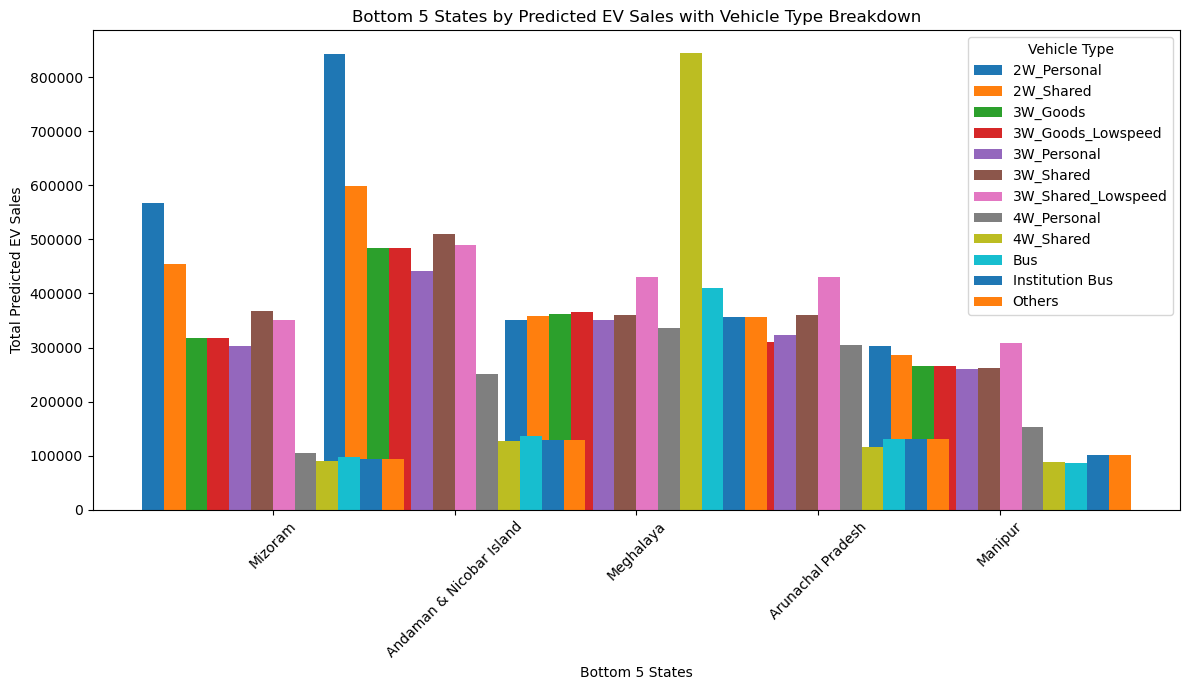

In [ ]:
# This groups all the predicted electric vehicle sales by state for future years, 
# then sorts the states so the ones with the lowest total predicted sales come first.
state_sales_future = future_df.groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=True)
# This selects the bottom 5 states with the lowest total predicted sales.
bottom5_states = state_sales_future.head(5).index
# This converts state codes (which are just numbers) back into real state names for clear chart labels.
bottom5_state_labels = label_encoders['State'].inverse_transform(bottom5_states)
# This keeps only the data for the bottom 5 states, ignoring the rest.# This keeps only the data for the bottom 5 states, ignoring the rest.
df_bottom5 = future_df[future_df['State'].isin(bottom5_states)]

# For the bottom 5 states, adds up all predicted sales for each type of vehicle, for each state.
# The unstack creates a table format where each column is a vehicle type.
grouped_bottom = df_bottom5.groupby(['State', 'Vehicle_Type'])['Predicted_EV_Sales'].sum().unstack(fill_value=0)
# This converts the vehicle type codes (numbers) back into readable names for each chart column.
vehicle_type_labels = label_encoders['Vehicle_Type'].inverse_transform(grouped_bottom.columns)
# Sets up the chart to be big enough (12 by 7 units) for easy reading.
fig, ax = plt.subplots(figsize=(12,7))
# Sets the width of each bar on the chart.
bar_width = 0.12
# Makes an array of positions for where the bars should start (one group for each state).
indices = np.arange(len(bottom5_state_labels))
# For each kind of vehicle, draws bars next to each other (not overlapping) so we can compare sales between types.
for i, vt in enumerate(grouped_bottom.columns):
    ax.bar(indices + i*bar_width, grouped_bottom[vt].values, bar_width, label=vehicle_type_labels[i])
# Sets the positions for state names so they line up in the center of each group of bars.
ax.set_xticks(indices + bar_width * (len(grouped_bottom.columns) - 1) / 2)
# Writes the actual state names below each group and tilts them for readability
ax.set_xticklabels(bottom5_state_labels, rotation=45)
# Labels the bottom of the chart to show these are the lowest (bottom) 5 states
ax.set_xlabel('Bottom 5 States')
# Labels the side of the chart so it’s clear these numbers are total predicted future sales.
ax.set_ylabel('Total Predicted EV Sales')
# Gives the chart a title, explaining it shows the lowest-sales states, including the types of vehicles sold.
ax.set_title('Bottom 5 States by Predicted EV Sales with Vehicle Type Breakdown')
# Adds a legend so each color or cluster is labeled with the correct vehicle type.
ax.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()

TOP 5 VEHICLE TYPES BY PREDICTED EV SALES 

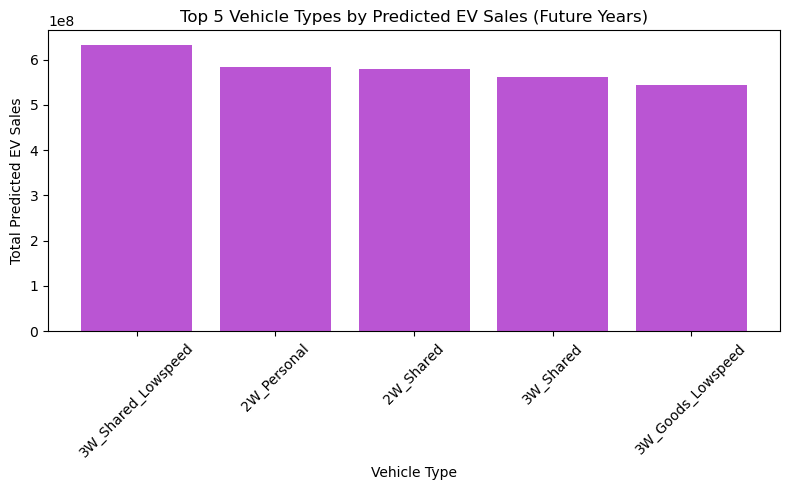

In [ ]:

# This groups all predicted electric vehicle sales by type of vehicle across all future years, 
# then adds up the sales for each type and sorts the types so the highest sales come first.
vehicle_sales_future = future_df.groupby('Vehicle_Type')['Predicted_EV_Sales'].sum().sort_values(ascending=False)

# Converts vehicle type codes (numbers) to easy-to-understand names for clear chart labels.
vehicle_labels = label_encoders['Vehicle_Type'].inverse_transform(vehicle_sales_future.index)

# Sets how many top vehicle types you want to display (e.g., top 5).
top_n = 5
# Picks the top vehicle types by predicted sales.
top_vehicle_sales = vehicle_sales_future.head(top_n)
# Converts the codes for these top vehicle types to readable names.
top_vehicle_labels = label_encoders['Vehicle_Type'].inverse_transform(top_vehicle_sales.index)
# Sets the size of the chart window.
plt.figure(figsize=(8,5))
# Draws a bar chart showing predicted sales for each of the top vehicle types, colored purple for visibility.
plt.bar(top_vehicle_labels, top_vehicle_sales.values, color='mediumorchid')
# Adds a clear title at the top explaining what's shown.
plt.title(f'Top {top_n} Vehicle Types by Predicted EV Sales (Future Years)')
# Labels the horizontal axis so viewers know these are the vehicle types.
plt.xlabel('Vehicle Type')
# Labels the vertical axis so it’s clear this is the total predicted number of electric vehicle sales.
plt.ylabel('Total Predicted EV Sales')
# Rotates the labels for easier reading if needed.
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TOP 5  STATES FOR PREDICTED EV SALES (3 WHEELER FOR CARRYING GOODS )

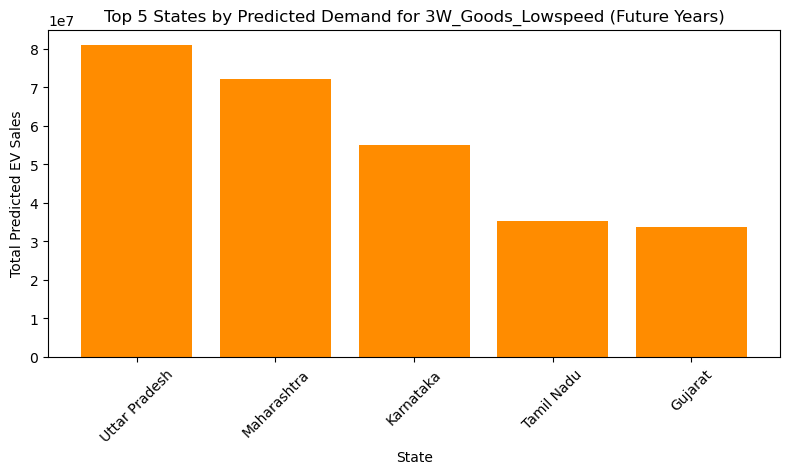

In [ ]:


# Encode the vehicle type label
# Save the specific vehicle type we are interested in. Here, it's "3W_Goods_Lowspeed" (three-wheeler, goods, low speed).
vehicle_type_label = '3W_Goods_Lowspeed'
# Convert that vehicle type label into a code (number) so the computer can use it to filter data.
vehicle_type_code = label_encoders['Vehicle_Type'].transform([vehicle_type_label])[0]

# Filter future predictions to only those of our chosen vehicle type
# Select only rows in our future dataset where the type of vehicle matches our chosen category.
df_3w_goods = future_df[future_df['Vehicle_Type'] == vehicle_type_code]


# Aggregate predicted sales by state
# Add up all the predicted electric vehicle sales for each state (just for the chosen vehicle type).
state_sales_3w = df_3w_goods.groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=False)

# Convert state codes to readable state names
# Turn state codes (numbers) back into actual state names, so the chart labels are easy to understand.
state_labels_3w = label_encoders['State'].inverse_transform(state_sales_3w.index)

# Select top 5 states by highest predicted sales
# Pick out the top 5 states with the highest predicted demand for our chosen vehicle type.
top_n = 5
top_states_3w = state_sales_3w.head(top_n)
# Turn those top state codes back into their state names for chart labeling.
top_states_labels_3w = label_encoders['State'].inverse_transform(top_states_3w.index)

# Plot the results!
# Set the chart size (width, height).
plt.figure(figsize=(8,5))
# Draw a bar chart showing the top state names along the bottom, and their predicted sales for our vehicle type.
plt.bar(top_states_labels_3w, top_states_3w.values, color='darkorange')
# Give the chart a title that explains what we're showing (top 5 states, chosen vehicle type, and future years).
plt.title(f'Top {top_n} States by Predicted Demand for {vehicle_type_label} (Future Years)')
# Label the x-axis so viewers know those are states.
plt.xlabel('State')
# Label the y-axis so viewers know those are total predicted future sales.
plt.ylabel('Total Predicted EV Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TOP 5 STATES BY PREDICTED EV SALES (3 WHEELER SHARED TRANSPORT/ E RIKSHAWS ETC)

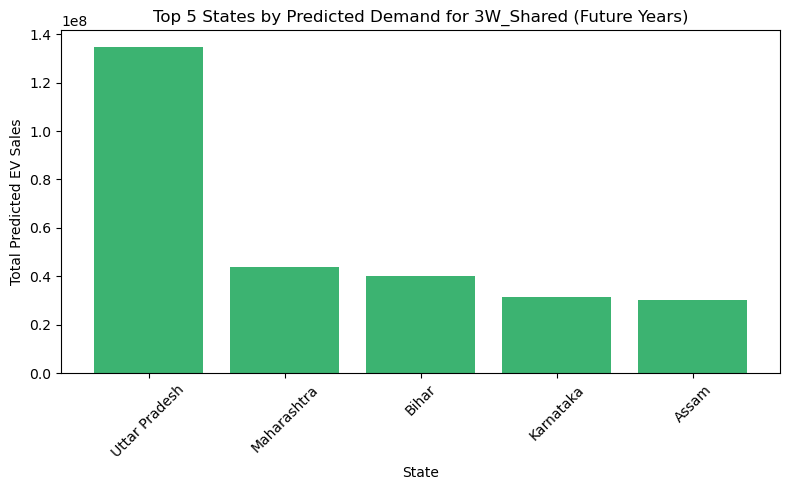

In [ ]:
# Store the name for the vehicle type we're interested in (here, "3W_Shared", which stands for shared three-wheeler vehicles)
vehicle_type_label = '3W_Shared'  

# Convert this name into a code (number), so the computer can use it to filter data efficiently
vehicle_type_code = label_encoders['Vehicle_Type'].transform([vehicle_type_label])[0]

# Select only future data rows that match the vehicle type we're interested in
df_3w_shared = future_df[future_df['Vehicle_Type'] == vehicle_type_code]

# Add up all predicted EV sales for each state, just for this vehicle type,
# and sort states from highest sales to lowest (so we can see where demand is largest)
state_sales_3w_shared = df_3w_shared.groupby('State')['Predicted_EV_Sales'].sum().sort_values(ascending=False)

# Convert state numbers back into actual state names for clear, friendly chart labels
state_labels_3w_shared = label_encoders['State'].inverse_transform(state_sales_3w_shared.index)

# Pick out the top 5 states by highest predicted sales for this vehicle type (so we can focus our chart)
top_n = 5
top_states_3w_shared = state_sales_3w_shared.head(top_n)
top_states_labels_3w_shared = label_encoders['State'].inverse_transform(top_states_3w_shared.index)

# Set up the chart size to be clear and easy to read
plt.figure(figsize=(8,5))
# Draw a bar chart showing state names on the bottom,
# and their predicted sales for the chosen vehicle type as colored bars
plt.bar(top_states_labels_3w_shared, top_states_3w_shared.values, color='mediumseagreen')
# Add a title to the chart explaining what the viewer is seeing
plt.title(f'Top {top_n} States by Predicted Demand for {vehicle_type_label} (Future Years)')
# Label the bottom axis (“State”) to show which region each bar represents
plt.xlabel('State')
# Label the side axis (“Total Predicted EV Sales”) so it’s clear what the numbers mean
plt.ylabel('Total Predicted EV Sales')
# Tilt the state labels so they don’t overlap and are easy to read
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()